<a href="https://colab.research.google.com/github/vpinnaka/aws-environment-hackathon/blob/master/autoencoder_baseline2_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Objectives
- Load data
- Re-order columns
- Add time encoding
- Separate weekday from weekend
- Explore sensor correlations
- Rescale/normalize
- Build sliding window representation 

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pathlib import Path
import time
import os

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd /content/drive/My Drive

/content/drive/My Drive


In [5]:
pwd

'/content/drive/My Drive'

In [6]:
dataset = pd.read_csv( index_col = 0,  parse_dates = True, infer_datetime_format = True, 
                         filepath_or_buffer = 'DMC20_Data/data/2018-01-01__2019-01-01__NConservatory__allMerged.csv')

In [7]:
dataset.index = pd.to_datetime(dataset.index, utc=True).tz_convert('America/Los_Angeles')

In [8]:
# Testing the model
import joblib
test_data = joblib.load('DMC20_Data/test_dataset_2019.numpy')
test_data.shape


(9898, 2112)

# Re-order columns [ facilitates cross-correlation analysis ]

In [9]:
orderedSensorList = ( 'co2_1','co2_2', 'co2_3', 'co2_4',                        
                      'temp_1', 'temp_2', 'temp_3', 'temp_4',                     
                      'dew_1','dew_2', 'dew_3', 'dew_4',
                      'relH_1', 'relH_2', 'relH_3', 'relH_4',
                      'externTemp_1', 
                      'externHumid_1', 
                      'externSunrise_1',                      
                      'externCondition_1' )        

In [10]:
orderedDataset = dataset.reindex( index = dataset.index, columns = orderedSensorList )

In [11]:
orderedDataset.shape

(34934, 20)

In [12]:
orderedDataset.head().T

2018-01-01 00:00:03-08:00  ...  2018-01-01 01:00:03-08:00
co2_1                             480.750000  ...                 486.612000
co2_2                             474.886993  ...                 474.886993
co2_3                             477.817993  ...                 477.817993
co2_4                             474.886993  ...                 477.817993
temp_1                             59.400002  ...                  58.799999
temp_2                             60.000000  ...                  59.200001
temp_3                             58.799999  ...                  57.799999
temp_4                             58.500000  ...                  57.700001
dew_1                              52.214100  ...                  51.862499
dew_2                              51.510899  ...                  51.335201
dew_3                              51.862499  ...                  51.159401
dew_4                              52.038300  ...                  51.335201
relH_1                             73.917000  ...                  74.635696
relH_2                             78.438202  ...                  79.967499
relH_3                             77.531898  ...                  79.274902
relH_4                             76.550697  ...                  76.205597
externTemp_1                       35.000000  ...                  35.000000
externHumid_1                      76.000000  ...                  77.000000
externSunrise_1                     1.000000  ...                   1.000000
externCondition_1                   4.000000  ...                   4.000000

[20 rows x 5 columns]

# Plot 2018 Data

In [13]:
plt.rcParams['figure.figsize'] = [ 20, 15 ] 
plt.rcParams['figure.subplot.left'] = plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.right'] = plt.rcParams['figure.subplot.top'] = .9

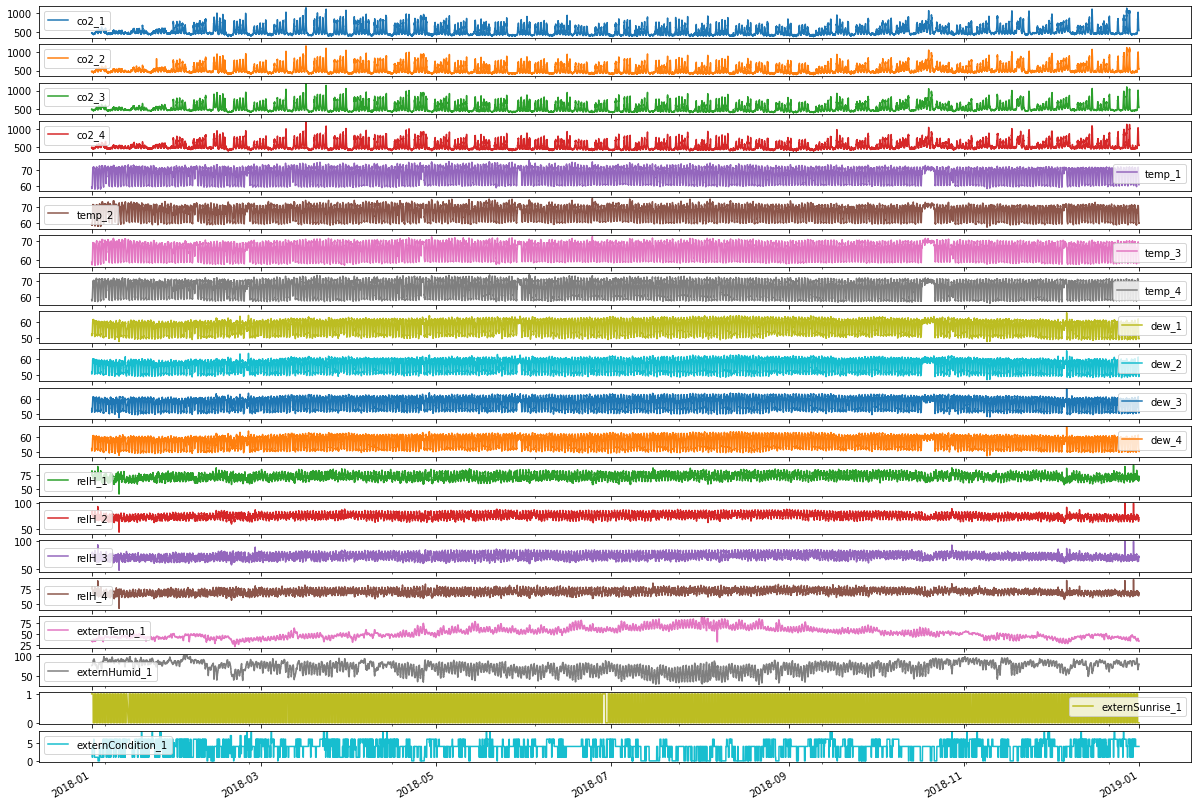

In [14]:
orderedDataset.plot( subplots = True );

# Separate Week from Weekend

### Add time encoding/reference (day and hour)

In [15]:
dayIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.dayofweek/6, decimals=2), 
                       name='dayIndex')
hourIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.hour/24, decimals=2), 
                       name='hourIndex')

In [16]:
orderedDatasetTimeReference = pd.concat([orderedDataset, hourIndexDF, dayIndexDF], axis=1)

In [17]:
orderedDatasetTimeReference["dayIndex"].index

DatetimeIndex(['2018-01-01 00:00:03-08:00', '2018-01-01 00:15:03-08:00',
               '2018-01-01 00:30:03-08:00', '2018-01-01 00:45:03-08:00',
               '2018-01-01 01:00:03-08:00', '2018-01-01 01:15:03-08:00',
               '2018-01-01 01:30:03-08:00', '2018-01-01 01:45:03-08:00',
               '2018-01-01 02:00:03-08:00', '2018-01-01 02:15:03-08:00',
               ...
               '2018-12-31 21:44:52-08:00', '2018-12-31 21:59:52-08:00',
               '2018-12-31 22:14:52-08:00', '2018-12-31 22:29:52-08:00',
               '2018-12-31 22:44:52-08:00', '2018-12-31 22:59:52-08:00',
               '2018-12-31 23:14:52-08:00', '2018-12-31 23:29:52-08:00',
               '2018-12-31 23:44:52-08:00', '2018-12-31 23:59:52-08:00'],
              dtype='datetime64[ns, America/Los_Angeles]', length=34934, freq=None)

In [18]:
saturdayVal = np.round(5/6,decimals=2)
sundayVal = np.round(6/6,decimals=2)

In [19]:
weekdayData = orderedDatasetTimeReference[ ( dayIndexDF != saturdayVal) &( dayIndexDF != sundayVal) ]

In [20]:
weekendData = orderedDatasetTimeReference[ ( dayIndexDF == saturdayVal) | (dayIndexDF == sundayVal) ]

In [21]:
weekdayData.shape, weekendData.shape

((25033, 22), (9901, 22))

# Explore Weekday and Weekend Sensor Cross-Correlations

In [22]:
xCorrWeekday = weekdayData.corr()
xCorrWeekend = weekendData.corr()

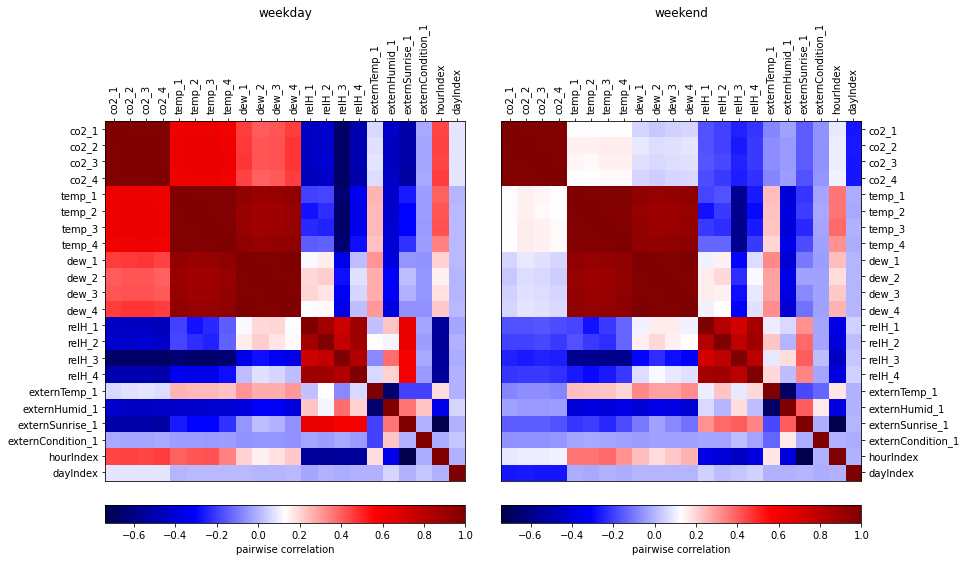

In [23]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.05, wspace=.1)

ax1 = plt.subplot(1,2,1)
im1 = plt.imshow(xCorrWeekday, cmap = plt.get_cmap('seismic'))
plt.xticks(range(0,len(xCorrWeekday)), labels=weekdayData.columns, rotation = 90)
plt.yticks(range(0,len(xCorrWeekday)), labels=weekdayData.columns)
plt.title('weekday')
ax1.xaxis.tick_top()

ax2 = plt.subplot(1,2,2)
im2 = plt.imshow(xCorrWeekend, cmap = plt.get_cmap('seismic'))
plt.xticks(range(0,len(xCorrWeekend)), labels=weekendData.columns, rotation = 90)
plt.yticks(range(0,len(xCorrWeekend)), labels=weekendData.columns)
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
plt.title('weekend')

fig.colorbar(im1, ax=ax1, label='pairwise correlation', orientation='horizontal', pad=.025)
fig.colorbar(im2, ax=ax2, label='pairwise correlation', orientation='horizontal', pad=.025)
plt.show()

# Rescale/Normalize [ focus on weekday data ]

In [24]:
continuousData = weekdayData.values[:, 0:17] # first 17 sensors are continuous valued
categoricalData = weekdayData.values[:, 17:]

standardScaler = StandardScaler()
standardScaler.fit( continuousData )

minMaxScaler = MinMaxScaler()
minMaxScaler.fit( categoricalData )

scaledContinuousData = standardScaler.transform(continuousData)
scaledCategoricalData = minMaxScaler.transform(categoricalData)

weekdayData_scaled =  pd.DataFrame( index = weekdayData.index,
                                    data = np.hstack( (scaledContinuousData, scaledCategoricalData)),
                                    columns = weekdayData.columns)

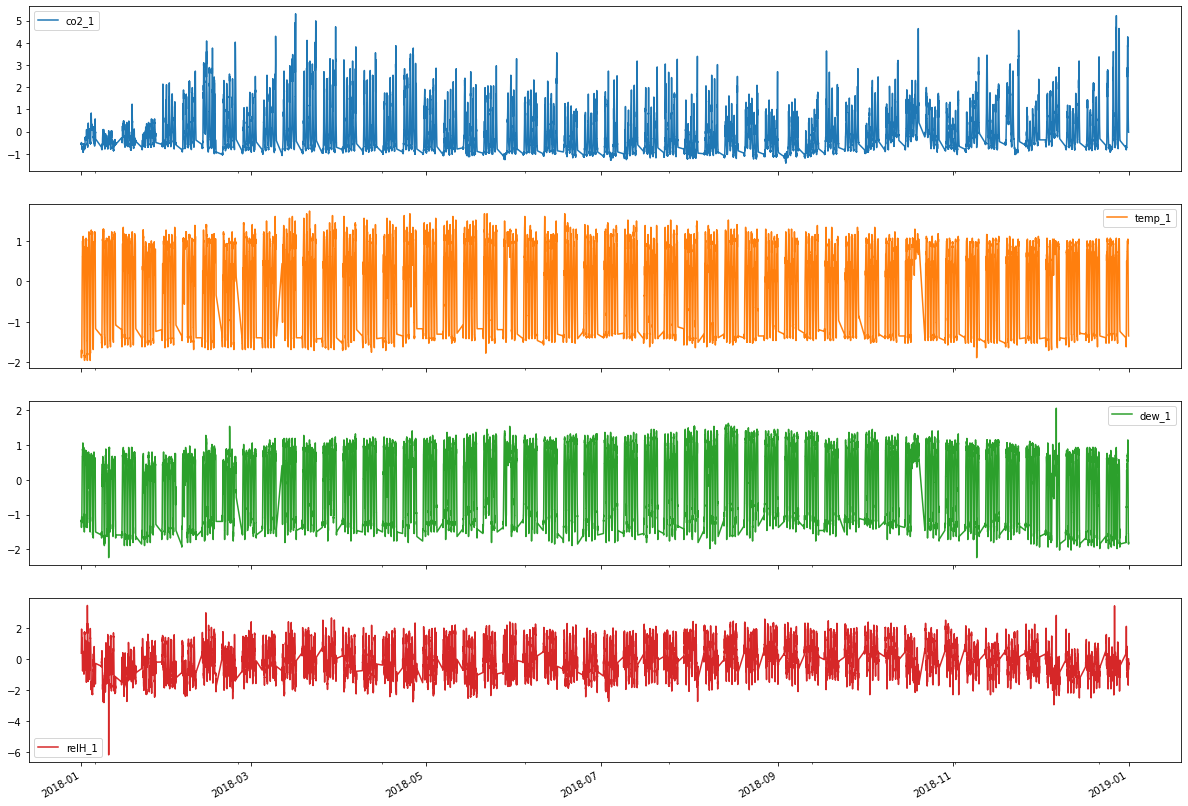

In [25]:
weekdayData_scaled[['co2_1', 'temp_1', 'dew_1', 'relH_1']].plot(subplots=True);

# Convert to Sliding Window Representation


In [26]:
def build_train_data ( inputDataframe, outputFilename, advanceTimedeltaStr = '15 min' ):

    npFilename = outputFilename + '.npy'
    npFilenameSamplebounds = outputFilename + '_sampleBounds' + '.npy'
    rebuildFlag = True # flips if file exists in cache and user agrees to restore

    windowCounter = correctLenWindows = fixedWindows = 1
    trimNeededWindows = extensionNeededWindows = 1
    sumExtensionAmount = sumTrimAmount = 0
    
    def extract_one_day( startTime, endTime, idealIndex, nExtensionAttempts=10 ):        
        nonlocal correctLenWindows, trimNeededWindows, extensionNeededWindows, \
                sumExtensionAmount, sumTrimAmount, fixedWindows

        oneDay = inputDataframe[ (inputDataframe.index >= startTime) \
                                         & (inputDataframe.index < endTime)]
        
        if len(oneDay) == len(idealIndex):
            correctLenWindows += 1

        # available data in day range is too long -- trimming required
        if len(oneDay) > len(idealIndex):
            trimNeededWindows += 1
            sumTrimAmount += len(oneDay) - len(idealIndex)
            oneDay = oneDay.iloc[0:len(idealIndex)]
        
        # available data in day range is of insufficient length -- extension required 
        if len(oneDay) < len(idealIndex):
            extensionNeededWindows += 1
            sumExtensionAmount += len(idealIndex) - len(oneDay)
            
            oneDay = None
            # attempt to extend one sample at a time up to nExtensionAttempts
            for iExtensionAttempt in range( nExtensionAttempts ):
                endTime += pd.Timedelta( advanceTimedeltaStr)
                extendedDay = inputDataframe[ (inputDataframe.index >= startTime) \
                                                 & (inputDataframe.index < endTime)]
                # sucessfully extened data slice
                if len( extendedDay) == len( idealIndex ):
                    fixedWindows += 1
                    oneDay = extendedDay
                    break
        
        # only happens when available data requires extension beyond nExtensionAttempts
        if oneDay is None:
            return None, None, None
        
        assert ( len(oneDay) == len(idealIndex) )
        return oneDay.values.reshape(1,-1, order = 'F'), oneDay.index[0], oneDay.index[-1]
    
    
    # check cache
    if Path(npFilename).is_file() and Path(npFilenameSamplebounds).is_file():
        print('created on: {} \n\t size: {} MB'.format( time.ctime(os.path.getctime(npFilename)), 
                                                        Path(npFilename).stat().st_size / 1e6 ))
        if 'y' == input('load from cache? (y/n): '):
            npTrainMatrix = np.load(npFilename, allow_pickle=True) # load from cache
            sampleIndexBounds = np.load(npFilenameSamplebounds, allow_pickle=True)
            rebuildFlag = False
    
    if rebuildFlag:
        npTrainMatrix = None
        sampleIndexBounds = None
        npTestMatrix = None

        startTime = inputDataframe.index[0]
        while(1):
            endTime = startTime + pd.Timedelta('1 day');
            
            # terminate window extraction once end of dataset is reached
            if startTime > inputDataframe.index[-1] or endTime > inputDataframe.index[-1]:
                break
            
            # generate an ideal index [ 96 x 15 min samples from current startTime ]
            idealIndex = pd.date_range(start=startTime, end=endTime, freq='15T', closed='left' );
            
            # ensure that current window is a weekday
            if (idealIndex.dayofweek < 5).all():
                
                # gather data from sensor streams going one day forward
                dataWindow, windowStartIndex, windowEndIndex = \
                    extract_one_day ( startTime, endTime, idealIndex)
                
                # dataWindow is none only when more than ~10 samples are missing                
                if dataWindow is not None:                
                    windowCounter += 1
                    
                    # first iteration is a direct assignment, all others require appending 
                    if npTrainMatrix is None:
                        npTrainMatrix = dataWindow;
                        sampleIndexBounds = np.array([windowStartIndex, windowEndIndex]);
                    else:
                        assert( dataWindow.shape[1] == npTrainMatrix.shape[1] ) # import ipdb; ipdb.set_trace()
                        npTrainMatrix = np.append( npTrainMatrix, dataWindow, axis = 0 );
                        sampleIndexBounds = np.append( sampleIndexBounds, 
                                                       np.array([windowStartIndex, windowEndIndex]) , axis = 0);
                        
            else:
                pass # skipping -- day segment includes a piece of the weekend
            
            avgTrim = np.round(sumTrimAmount/trimNeededWindows, decimals=2);
            avgExtend = np.round(sumExtensionAmount/extensionNeededWindows, decimals=2);
            
            # advance to next sample
            startTime = startTime + pd.Timedelta(advanceTimedeltaStr);

        print('nWindows {} - nCorrect {}; nTrimNeeded {} | avg.trim {}; nExtendNeeded {} | avg.ext {} | fixedViaExtension {}'.format(windowCounter, correctLenWindows, 
                       trimNeededWindows, avgTrim, extensionNeededWindows, avgExtend, fixedWindows), end='\r')

        print('\nwriting to cache')
        
        # save to cache
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        np.save(npFilename, npTrainMatrix)
        np.save(npFilenameSamplebounds, sampleIndexBounds)

    if sampleIndexBounds.shape[0] != npTrainMatrix.shape[0]:
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        
    return npTrainMatrix, sampleIndexBounds

expected output if rebuilding without cache:
  > nWindows 20008 - nCorrect 17928; nTrimNeeded 439 | avg.trim 3.99; nExtendNeeded 1656 | avg.ext 1.56 | fixedViaExtension 1643        
  > Wall time: 35min 53s 

In [27]:
%%time
outputFilename = 'DMC20_Data/data/2018-01-01__2019-01-01__NConservatory_npWeekdayAllOrderedSensorsTimeRef'
npTrainMatrix, sampleIndexBounds = build_train_data ( weekdayData_scaled, outputFilename )

created on: Tue Aug 11 00:30:49 2020 
	 size: 338.0384 MB
load from cache? (y/n): y
CPU times: user 300 ms, sys: 169 ms, total: 469 ms
Wall time: 9.92 s


In [28]:
sampleIndexBounds[0]

array([Timestamp('2018-01-01 00:00:03-0800', tz='America/Los_Angeles'),
       Timestamp('2018-01-01 23:45:03-0800', tz='America/Los_Angeles')],
      dtype=object)

In [29]:
len(weekdayData_scaled)

25033

In [30]:
npTrainMatrix.shape

(20007, 2112)

# Plot Sliding Windows

In [31]:
samplesInADay = 96 # 96 samples 15 minutes apart = 24 hours 

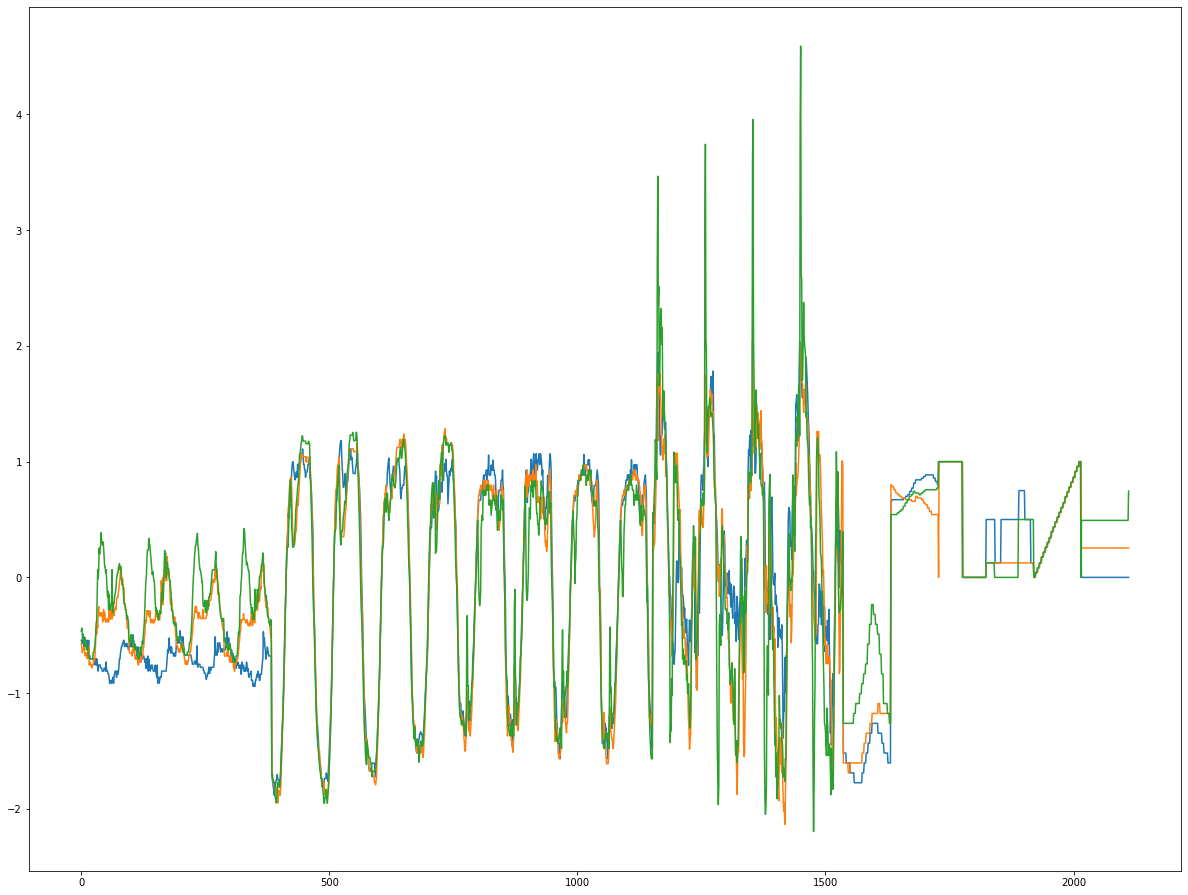

In [32]:
nSlidingWindowsToPlot = 3
plt.figure()
for iDay in range(nSlidingWindowsToPlot):
    startIndex = (iDay) * samplesInADay
    plt.plot(npTrainMatrix[startIndex,:])

In [33]:
npTrainMatrix.shape

(20007, 2112)

In [34]:
weekdayData_scaled.describe()

co2_1         co2_2  ...     hourIndex      dayIndex
count  2.503300e+04  2.503300e+04  ...  25033.000000  25033.000000
mean   1.196934e-15  7.457095e-15  ...      0.498262      0.496666
std    1.000020e+00  1.000020e+00  ...      0.301174      0.353326
min   -1.421144e+00 -1.383592e+00  ...      0.000000      0.000000
25%   -7.423146e-01 -7.436227e-01  ...      0.218750      0.253731
50%   -3.581802e-01 -3.667208e-01  ...      0.479167      0.492537
75%    5.187722e-01  5.197907e-01  ...      0.739583      0.746269
max    5.302129e+00  5.604175e+00  ...      1.000000      1.000000

[8 rows x 22 columns]

In [35]:
weekdayData_scaled.columns

Index(['co2_1', 'co2_2', 'co2_3', 'co2_4', 'temp_1', 'temp_2', 'temp_3',
       'temp_4', 'dew_1', 'dew_2', 'dew_3', 'dew_4', 'relH_1', 'relH_2',
       'relH_3', 'relH_4', 'externTemp_1', 'externHumid_1', 'externSunrise_1',
       'externCondition_1', 'hourIndex', 'dayIndex'],
      dtype='object')

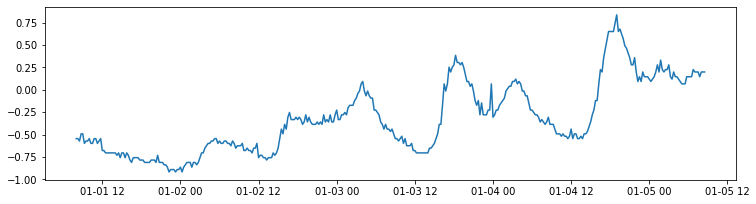

In [36]:
plt.figure(figsize=(12,3))
plt.plot(weekdayData_scaled['co2_1'][96*0:96*4])

# Split train/val/test data

In [37]:
# targetDevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceCPU

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [39]:
n = len(npTrainMatrix)

In [40]:
X_train = npTrainMatrix #[:int(n*0.75), :]
X_test = npTrainMatrix[int(n*0.75):, :]

In [41]:
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

In [42]:
dataLoaderTrain = DataLoader( X_train.astype('float32'), 
                              batch_size = 128, 
                              shuffle = True ) # could adjust batch size

dataLoaderTest = DataLoader( X_test.astype('float32'), 
                             batch_size = 1, 
                             shuffle = False )

In [43]:
inputDimensionality = X_train.shape[1]

model = nn.Sequential (
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.Sigmoid(),
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)

## construct labeled data set

In [168]:
# np.random.seed(30)
randomRows = np.random.choice(len(npTrainMatrix),300, replace = False)
labels = np.zeros(len(npTrainMatrix))
labels[randomRows] = 1

In [169]:
import copy
constructedData = np.random.permutation(npTrainMatrix)  # shuffled training data
constructedData2 = copy.copy(constructedData) 

In [170]:
for j in randomRows:
  i = np.random.choice(16)
  constructedData2[j, 96*(i):96*(i+1)] +=  10*np.random.choice([1,-1]) # simple translate up/down
  # constructedData2[j, 96*(i):96*(i+1)] *=  2*np.random.choice([1,-1])


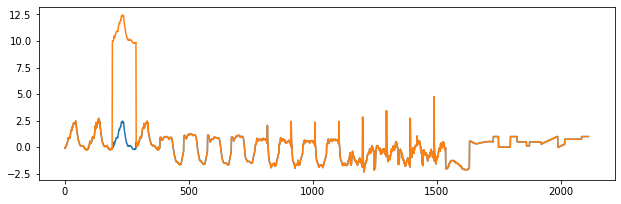

In [171]:
plt.figure(figsize = (10,3))
plt.plot(constructedData[randomRows[13],:])
plt.plot(constructedData2[randomRows[13],:])

In [107]:
test_mae_loss.shape

(20007,)

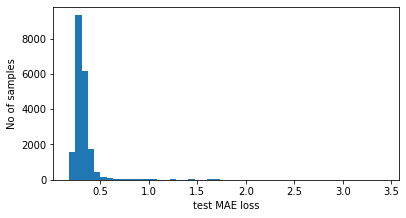

In [172]:
# Get test MAE loss.
testingData = constructedData2.astype(np.float32)
x_test_pred = model.forward(torch.from_numpy(testingData))

# test_mae_loss = np.mean(np.abs(testingData[:,:16*96] - x_test_pred[:,:16*96].detach().numpy()), axis = 1)
test_mae_loss = np.quantile(np.abs(testingData[:,:16*96] - x_test_pred[:,:16*96].detach().numpy()), 0.9,axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.figure(figsize=(6,3)) 
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
# threshold = 0.45
# anomalies = (test_mae_loss > threshold).tolist()
# print("Number of anomaly samples: ", np.sum(anomalies))
# print("Indices of anomaly samples: ", np.where(anomalies))

In [173]:
idx = (-test_mae_loss).argsort()[:300] # predicted windows where anomaly exists
pred = np.zeros(len(npTrainMatrix))
pred[idx] = 1

In [174]:
TP = 0
FN = 0
FNs = []
TPs = []
for i in randomRows:
  if pred[i] == 1:
    TP += 1
    TPs.append(i)
  else:
    FN += 1
    FNs.append(i)

In [175]:
TN = 0
FP = 0
FPs = []
TNs = []
idx_neg = [curr for curr,i in enumerate(labels) if i == 0]

for i in idx_neg:
  if pred[i] == 0:
    TN += 1
    TNs.append(i)
  else:
    FP += 1  
    FPs.append(i)

In [176]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(labels, pred) # This score corresponds to the area under the precision-recall curve.

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.56


In [177]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(labels, pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.99609276 0.74333333]
recall: [0.99609276 0.74333333]
fscore: [0.99609276 0.74333333]
support: [19707   300]


In [178]:
print(TP/(TP+FP))
print('TP = {0}, TN = {1}, FP = {2}, FN = {3}'.format(TP, TN, FP, FN))

0.7433333333333333
TP = 223, TN = 19630, FP = 77, FN = 77


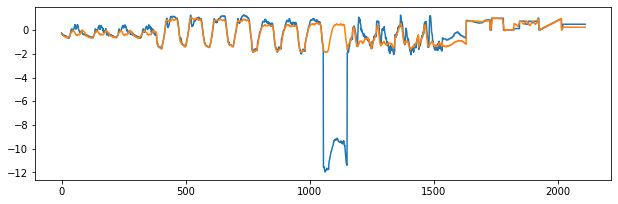

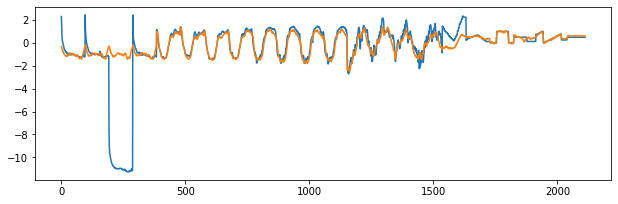

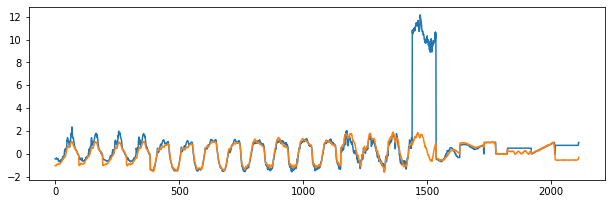

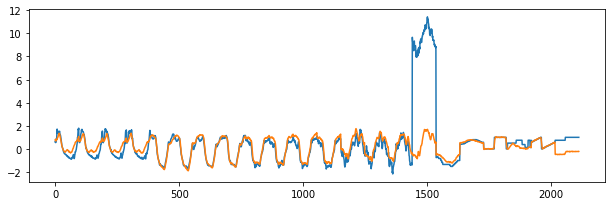

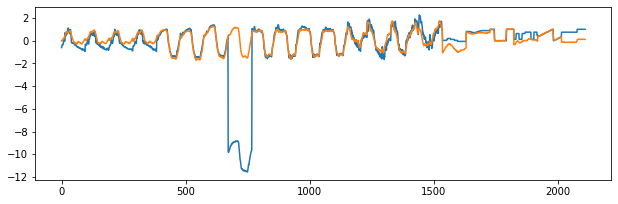

In [179]:
# False negatives
for i in range(5):
  plt.figure(figsize=(10, 3))
  plt.plot(testingData[FNs[i], :])
  plt.plot(x_test_pred.detach().numpy()[FNs[i],:])

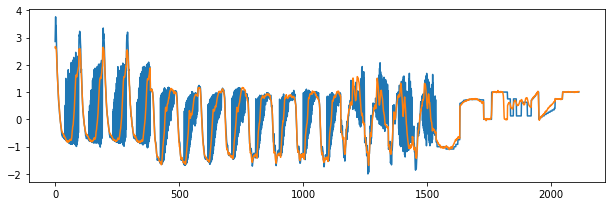

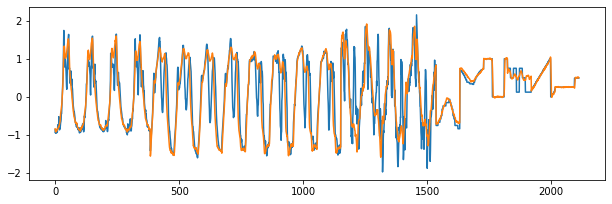

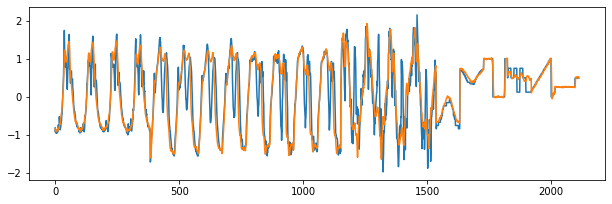

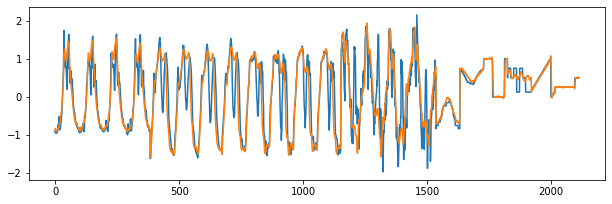

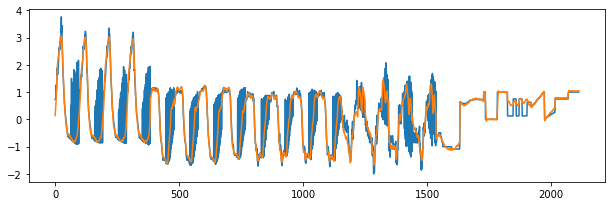

In [165]:
# false positives
for i in range(5):
  plt.figure(figsize=(10, 3))
  plt.plot(testingData[FPs[i], :])
  plt.plot(x_test_pred.detach().numpy()[FPs[i],:])

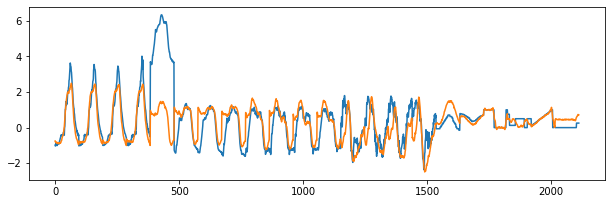

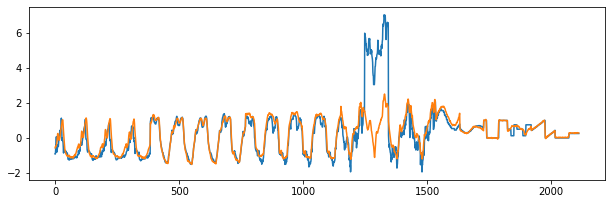

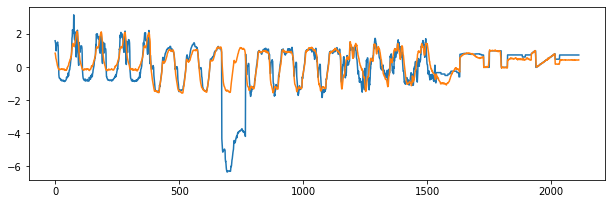

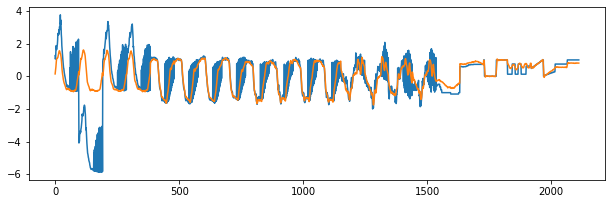

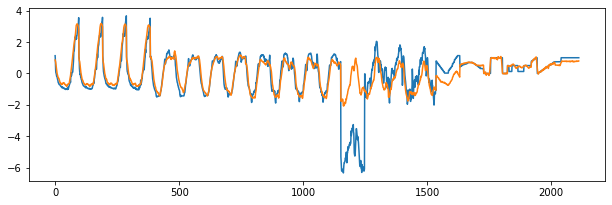

In [166]:
# true positives
for i in range(5):
  plt.figure(figsize=(10, 3))
  plt.plot(testingData[TPs[i], :])
  plt.plot(x_test_pred.detach().numpy()[TPs[i],:])

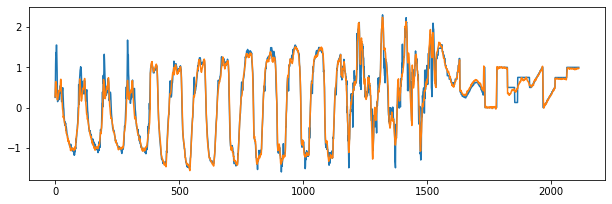

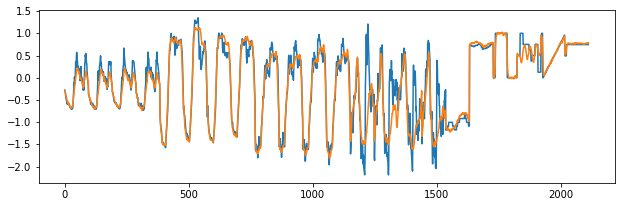

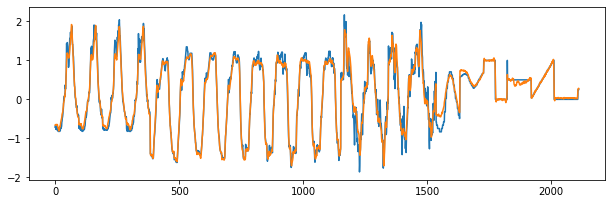

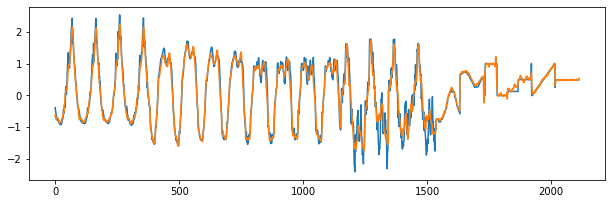

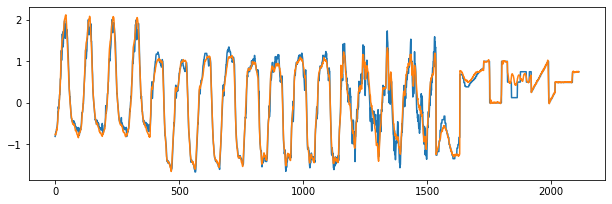

In [167]:
for i in range(5):
  plt.figure(figsize=(10, 3))
  plt.plot(testingData[TNs[i], :])
  plt.plot(x_test_pred.detach().numpy()[TNs[i],:])

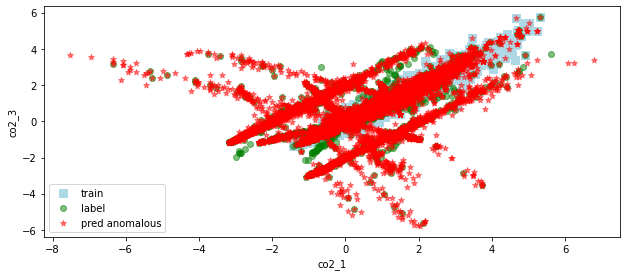

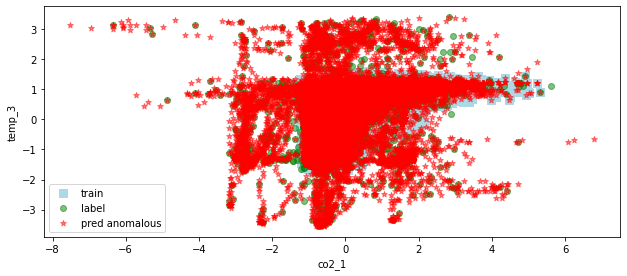

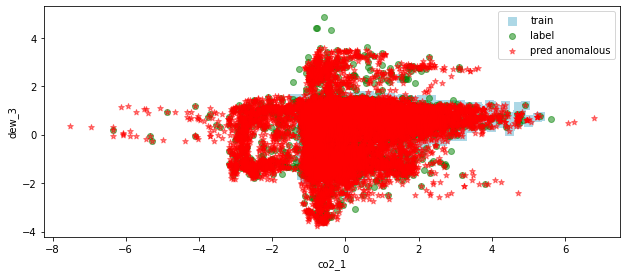

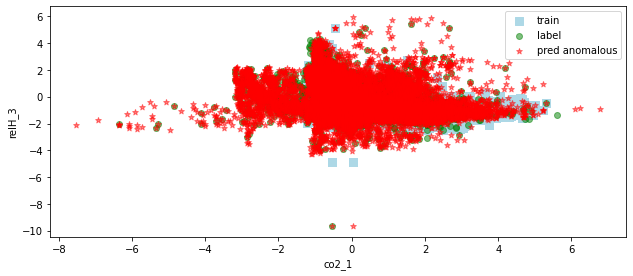

In [151]:
f1 = 0
# f2 = 2
for f2 in [2,6,10,14]:
  fig, ax = plt.subplots(figsize=(10,4))
  ax.scatter(constructedData[:, 96*f1:96*(f1+1):7],constructedData[:, 96*f2:96*(f2+1):7], marker="s", s = 80, color="lightBlue", label = "train")
  ax.scatter(constructedData2[randomRows, 96*f1:96*(f1+1):7], constructedData2[randomRows, 96*f2:96*(f2+1):7], marker="o", color='Green', alpha = 0.5, label = "label")
  ax.scatter(constructedData2[idx, 96*f1:96*(f1+1)], constructedData2[idx, 96*f2:96*(f2+1)], marker ="*",color='Red', alpha = 0.5, label = "pred anomalous")
  
  # ax.scatter(test_data[anomalies, 96*f1:96*(f1+1)], test_data[anomalies, 96*f2:96*(f2+1)], marker ="*",color='Red', alpha = 0.5, label = "anomalous")

  plt.legend()
  plt.xlabel(weekdayData_scaled.columns[f1])
  plt.ylabel(weekdayData_scaled.columns[f2])

# Train Model

In [46]:
def train_model ( model, dataLoader, targeDevice, nEpochs = 10 ):

    model = model.to( targetDevice )
    
#     lossFunction = nn.MSELoss()
    lossFunction = nn.L1Loss()
    optimizer = torch.optim.Adam( model.parameters())
    lossHistory = []
    history = dict(train=[], val=[])
    batchLoss = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
            
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLoss += loss.item() # gets scaler value held in the loss tensor
            
            # compute gradients by propagating the error backward through the model/graph
            loss.backward()

            # apply gradients to update model parameters
            optimizer.step()
            batchLoss.append(loss.item())
        print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory, batchLoss

In [47]:
startTime = time.time()

model, lossHistory, batchLoss = train_model( model, dataLoaderTrain, targetDevice, nEpochs = 100 )

print('elapsed time : {} '.format(time.time() - startTime))
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

epoch 0 of 100 -- avg batch loss: 84.8584415614605
epoch 1 of 100 -- avg batch loss: 48.74319279193878
epoch 2 of 100 -- avg batch loss: 40.84487561881542
epoch 3 of 100 -- avg batch loss: 38.603647008538246
epoch 4 of 100 -- avg batch loss: 37.7859803289175
epoch 5 of 100 -- avg batch loss: 37.280342161655426
epoch 6 of 100 -- avg batch loss: 36.83063794672489
epoch 7 of 100 -- avg batch loss: 36.491669192910194
epoch 8 of 100 -- avg batch loss: 36.235192000865936
epoch 9 of 100 -- avg batch loss: 36.016454353928566
epoch 10 of 100 -- avg batch loss: 35.767525151371956
epoch 11 of 100 -- avg batch loss: 35.512734308838844
epoch 12 of 100 -- avg batch loss: 35.07810415327549
epoch 13 of 100 -- avg batch loss: 33.80576413869858
epoch 14 of 100 -- avg batch loss: 32.50365577638149
epoch 15 of 100 -- avg batch loss: 31.49813088774681
epoch 16 of 100 -- avg batch loss: 30.649664252996445
epoch 17 of 100 -- avg batch loss: 30.100503847002983
epoch 18 of 100 -- avg batch loss: 29.76544001698

In [59]:
MODEL_PATH = 'model.pth'
model = torch.load(MODEL_PATH)

Gaussian distribution

In [48]:
weekdayData_scaled.columns

Index(['co2_1', 'co2_2', 'co2_3', 'co2_4', 'temp_1', 'temp_2', 'temp_3',
       'temp_4', 'dew_1', 'dew_2', 'dew_3', 'dew_4', 'relH_1', 'relH_2',
       'relH_3', 'relH_4', 'externTemp_1', 'externHumid_1', 'externSunrise_1',
       'externCondition_1', 'hourIndex', 'dayIndex'],
      dtype='object')

In [52]:
test_data.shape

(9898, 2112)

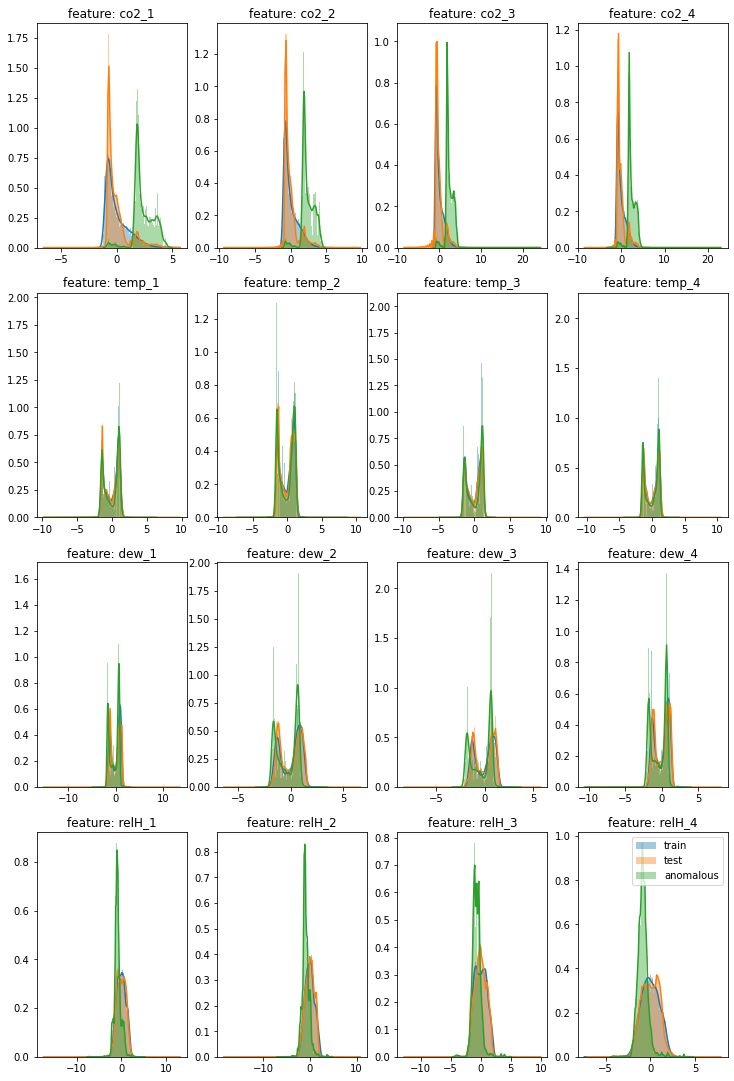

In [130]:
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, cn in enumerate(weekdayData_scaled.columns[:16]):
    ax = plt.subplot(gs[i])
    sns.distplot(weekdayData_scaled[cn], bins=100, label = 'train') # train data
    sns.distplot(test_data[:,96*i:96*(i+1)], bins=100, label = 'test') # test data
    sns.distplot(test_data[anomalies,96*i:96*(i+1)], bins=100, label = 'anomalous') # anomolous data
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.legend()
plt.show()

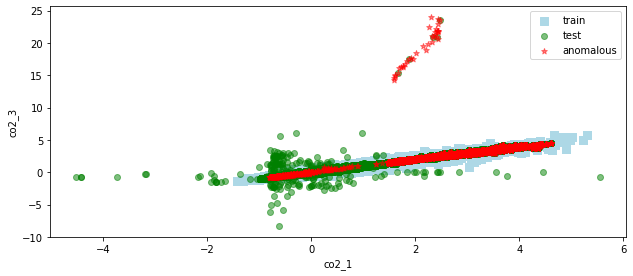

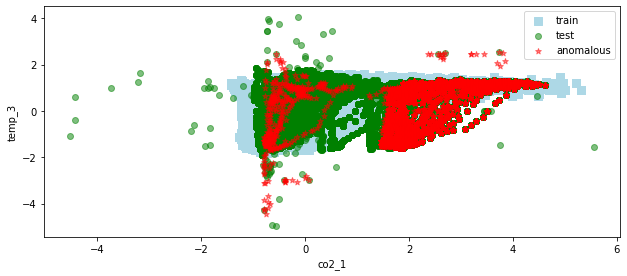

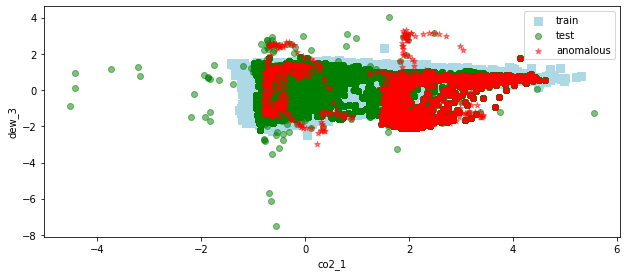

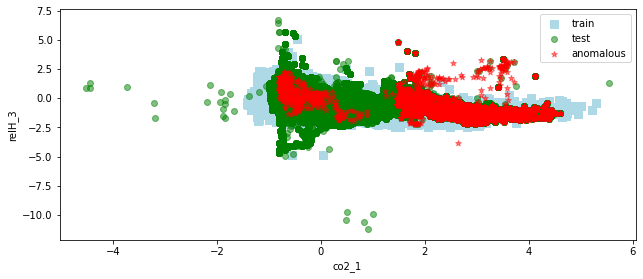

In [140]:
f1 = 0
# f2 = 2
for f2 in [2,6,10,14]:
  fig, ax = plt.subplots(figsize=(10,4))
  ax.scatter(X_train[:, 96*f1:96*(f1+1):7],X_train[:, 96*f2:96*(f2+1):7], marker="s", s = 80, color="lightBlue", label = "train")
  ax.scatter(test_data[:, 96*f1:96*(f1+1):7], test_data[:, 96*f2:96*(f2+1):7], marker="o", color='Green', alpha = 0.5, label = "test")
  ax.scatter(test_data[anomalies, 96*f1:96*(f1+1)], test_data[anomalies, 96*f2:96*(f2+1)], marker ="*",color='Red', alpha = 0.5, label = "anomalous")
  
  # ax.scatter(test_data[anomalies, 96*f1:96*(f1+1)], test_data[anomalies, 96*f2:96*(f2+1)], marker ="*",color='Red', alpha = 0.5, label = "anomalous")

  plt.legend()
  plt.xlabel(weekdayData_scaled.columns[f1])
  plt.ylabel(weekdayData_scaled.columns[f2])

# for i, txt in enumerate(train_test['V14'].index):
#        if train_test_y.loc[txt] == 1 :
#             ax.annotate('*', (train_test['V14'].loc[txt],train_test['V11'].loc[txt]),fontsize=13,color='Red')
#        if predictions[i] == True :
#             ax.annotate('o', (train_test['V14'].loc[txt],train_test['V11'].loc[txt]),fontsize=15,color='Green')

In [113]:
ls = test_data[0:20:2,1]
print(ls)

[ 0.37100625 -0.73877635 -0.59275201 -0.28610361 -0.27149936 -0.62195582
 -0.82639308  0.26879011 -0.79718912  0.2103822 ]


In [149]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(X_train[0,:].reshape(1,-1))


res=pd.DataFrame(pca.transform(X_train[0,:]))

Z = np.array(res)
figsize=(12, 7)
plt.figure(figsize=figsize)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(res[0], res[1], c='blue',
                 s=40,label="normal points")

b1 = plt.scatter(res.iloc[anomalies,0],res.iloc[anomalies,1], c='red',
                 s=40,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

ValueError: ignored

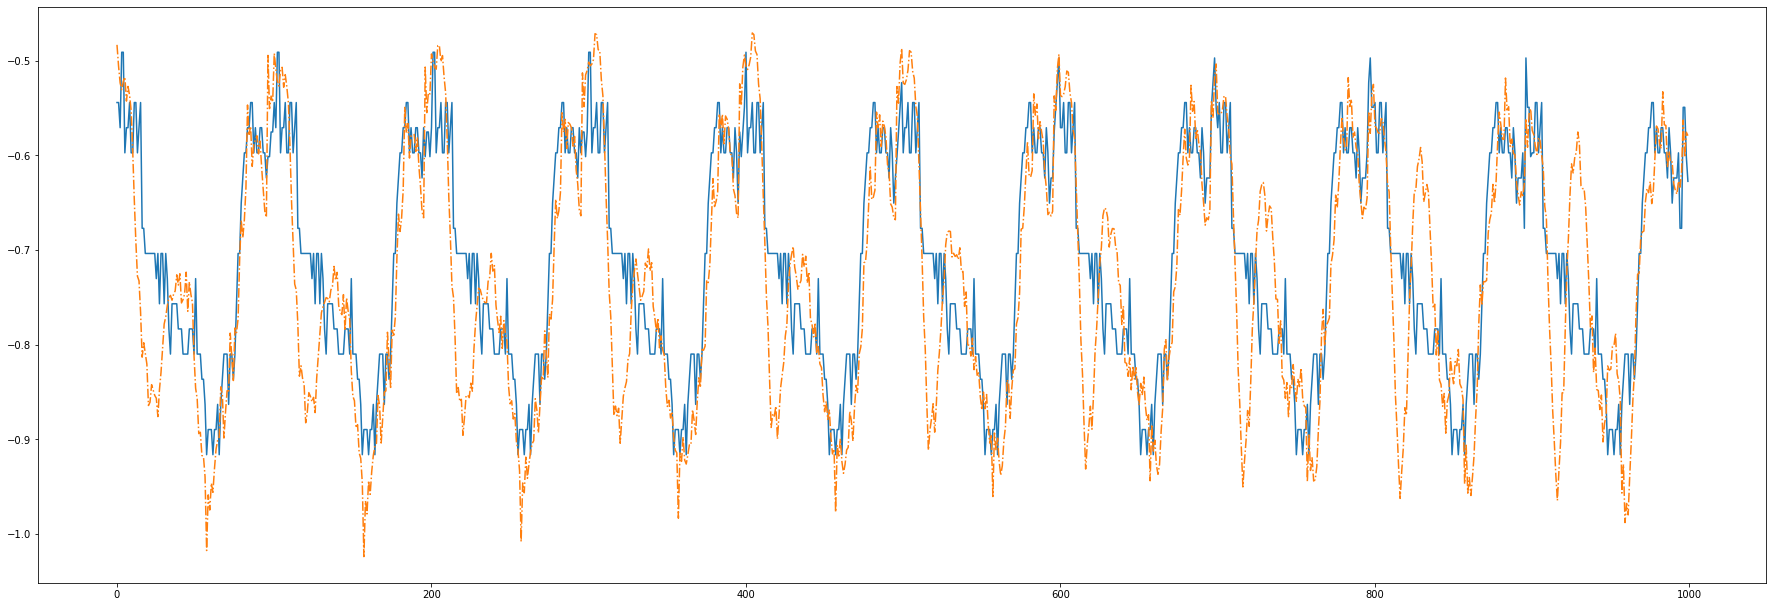

In [73]:
plt.figure(figsize= (30,10))
plt.plot(trainingData[:10,:100].reshape(-1,1))
plt.plot(x_train_pred.detach().numpy()[:10,:100].reshape(-1,1),'-.')

### Visualize Progression of Learning

In [122]:
plt.figure(figsize=(6,3))
plt.plot(lossHistory)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

NameError: ignored

<Figure size 432x216 with 0 Axes>

In [79]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

state = np.random.RandomState(42)

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=96, 
                                       random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [141]:
m2 = IsolationForest(n_estimators=100, max_samples=96, 
                                       random_state=state, verbose=0)
m2.fit(X_train)
scores_prediction = m2.decision_function(X_train)
y_pred = m2.predict(X_train)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1 # anomaly

In [142]:
sum(y_pred)

5984

In [81]:

for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    else:    
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
    
    # #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    # y_pred[y_pred == 1] = 0
    # y_pred[y_pred == -1] = 1
    # n_errors = (y_pred != Y).sum()
    # # Run Classification Metrics
    # print("{}: {}".format(clf_name,n_errors))
    # print("Accuracy Score :")
    # print(accuracy_score(Y,y_pred))
    # print("Classification Report :")
    # print(classification_report(Y,y_pred))

KeyboardInterrupt: ignored

# Evaluate Model Performance

In [52]:
targetDevice

device(type='cpu')

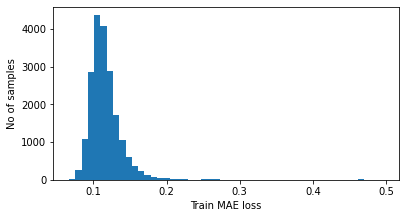

Reconstruction error threshold:  0.49612415
Number of anomaly samples:  0


In [138]:
# Get train MAE loss.
# trainingData = X_train.astype(np.float32)
trainingData = npTrainMatrix.astype(np.float32)
x_train_pred = model.forward(torch.from_numpy(trainingData))
train_mae_loss = np.mean(np.abs(trainingData - x_train_pred.cpu().detach().numpy()),axis = 1)

plt.figure(figsize=(6,3)) 
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
# threshold = np.quantile(train_mae_loss,0.99)
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

# Detect all the samples which are anomalies.
anomalies = (train_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))

In [ ]:
train_mae_loss[0]

In [54]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] contain anomalies
anomalous_data_indices = []
TIME_STEPS = 96
test_value = X_test
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if any([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

In [55]:
len(anomalous_data_indices)

0

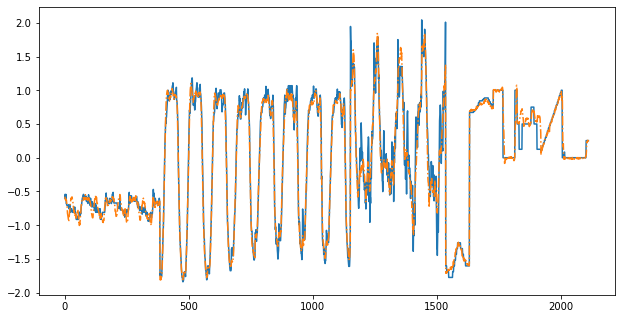

In [71]:
plt.figure(figsize=(10,5))
plt.plot(X_train[10,:].reshape(-1,1))
plt.plot(x_train_pred[10,:].reshape(-1,1).detach().numpy(),'-.')

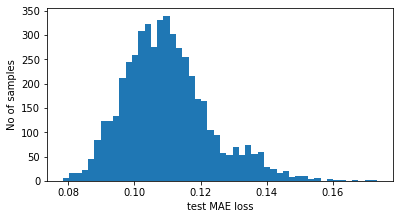

Number of anomaly samples:  0


In [137]:
# Get test MAE loss.
# x_test_pred = model.predict(x_test)
testingData = X_test.astype(np.float32)
x_test_pred = model.forward(torch.from_numpy(testingData))

test_mae_loss = np.mean(np.abs(testingData - x_test_pred.detach().numpy()), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.figure(figsize=(6,3)) 
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
# print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
TIME_STEPS = 96
test_value=X_test
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if any([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

In [ ]:
len(anomalous_data_indices)

In [58]:
def evaluate_model ( model, dataLoader, targetDevice, nEvals = 3):

    for iSample in range(nEvals):

        sample = iter(dataLoader).next()[0] # get first element from sample batch        
        reconstruction = model.forward(sample.to(targetDevice))

        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        # error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )
        error = np.abs(sampleNumpy - reconstructionNumpy)
        # print(sampleNumpy.shape)

        plt.figure(figsize=(18,10))
        ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
        ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    

        ax1.plot(sampleNumpy)
        ax1.plot(reconstructionNumpy, '-.')
        ax1.set_title('sample {}, total error {}'.format(iSample, np.sum(error)))
        ax1.legend(['input data', 'reconstruction'])

        ax2.plot(error)
        ax2.legend( ['reconstruction error'] )


In [59]:
def plot_model_window ( model, dataLoader, targetDevice, idx):

    for iSample in range(0, idx+1):
        if(iSample != idx):
          continue
        sample = iter(dataLoader).next()[0] # get first element from sample batch        
        reconstruction = model.forward(sample.to(targetDevice))

        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        # error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )
        error = np.abs(sampleNumpy - reconstructionNumpy)


    plt.figure(figsize=(18,10))
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
    ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    

    ax1.plot(sampleNumpy)
    ax1.plot(reconstructionNumpy, '-.')
    ax1.set_title('sample {}, total error {}'.format(iSample, np.sum(error)))
    ax1.legend(['input data', 'reconstruction'])

    ax2.plot(error)
    ax2.legend( ['reconstruction error'] )


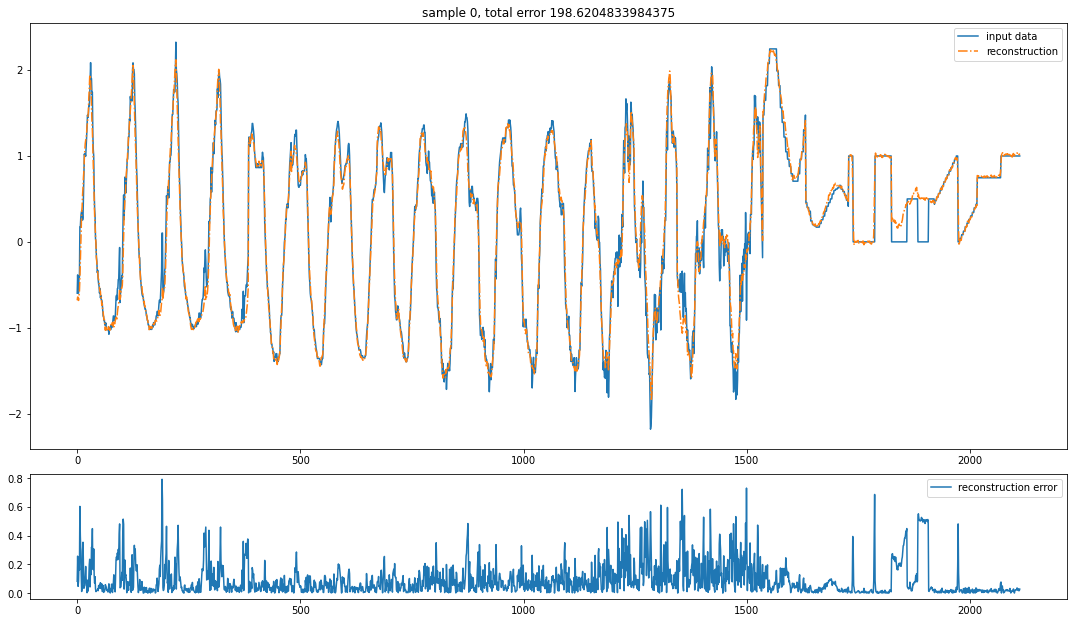

In [60]:
plot_model_window ( model, dataLoaderTrain, targetDevice, 0)

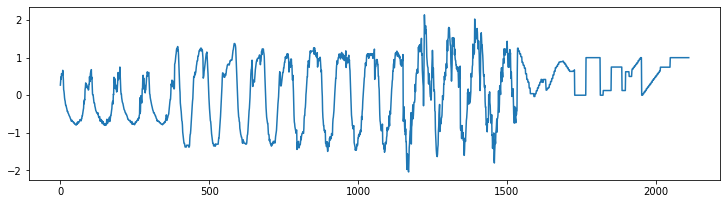

In [61]:
plt.figure(figsize=(12,3))
plt.plot(test_data[0])

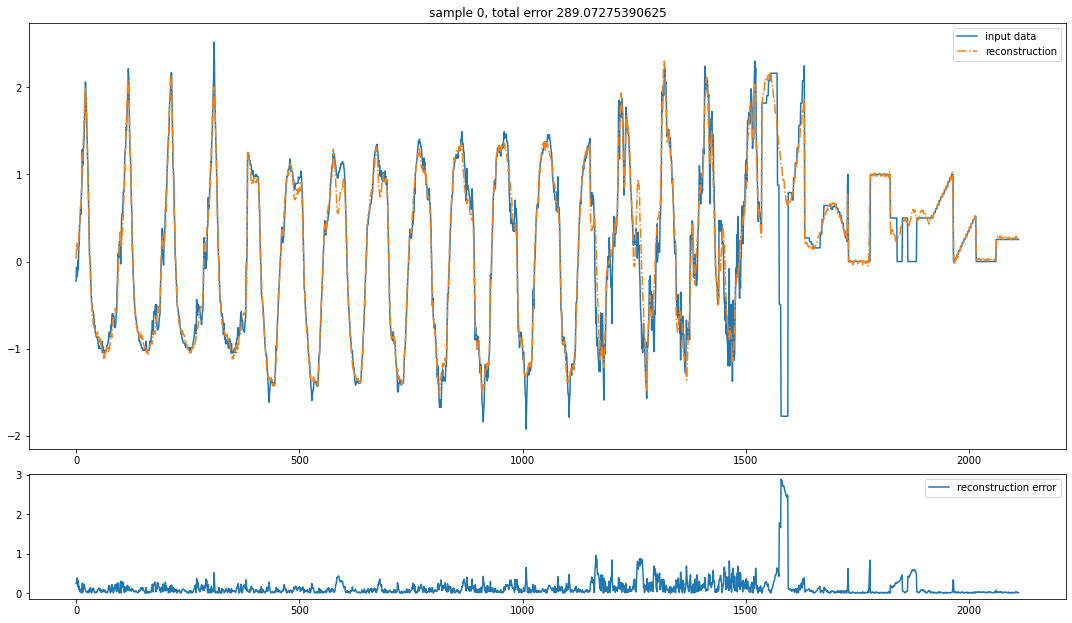

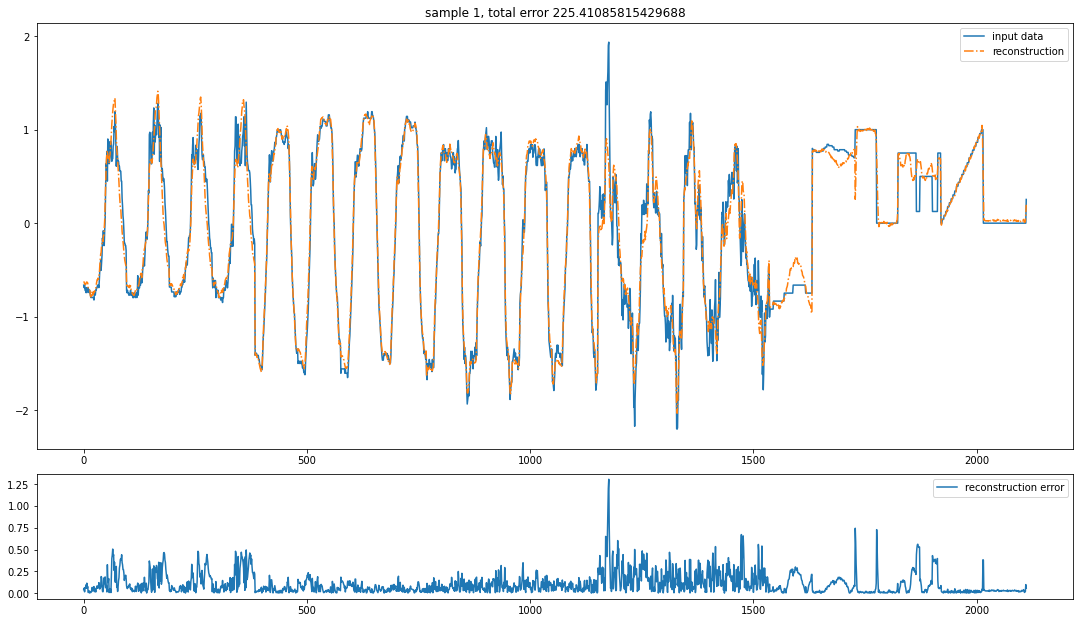

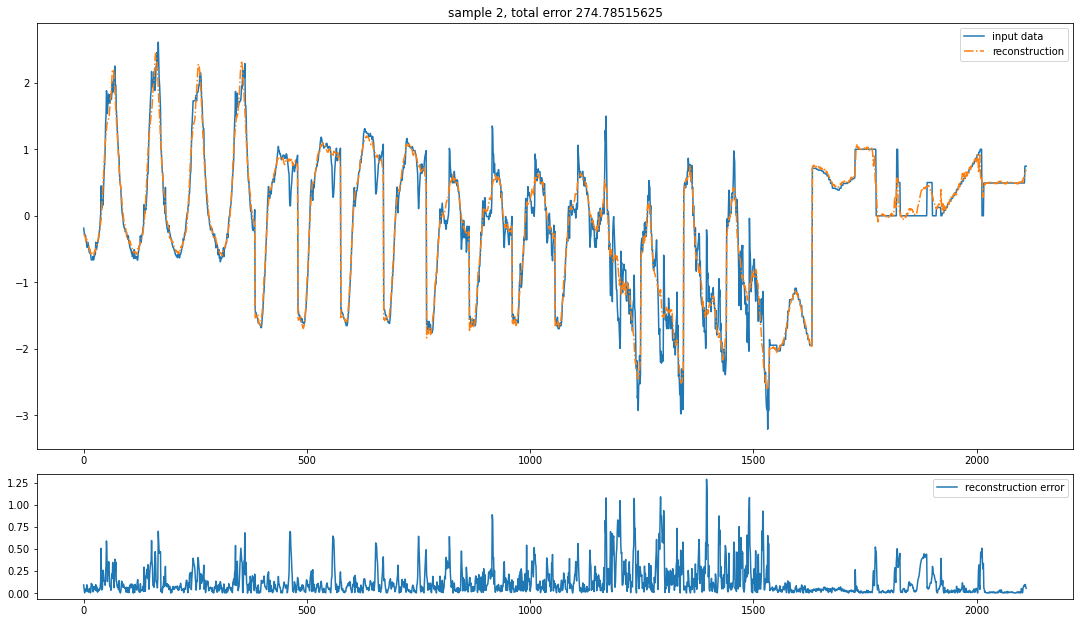

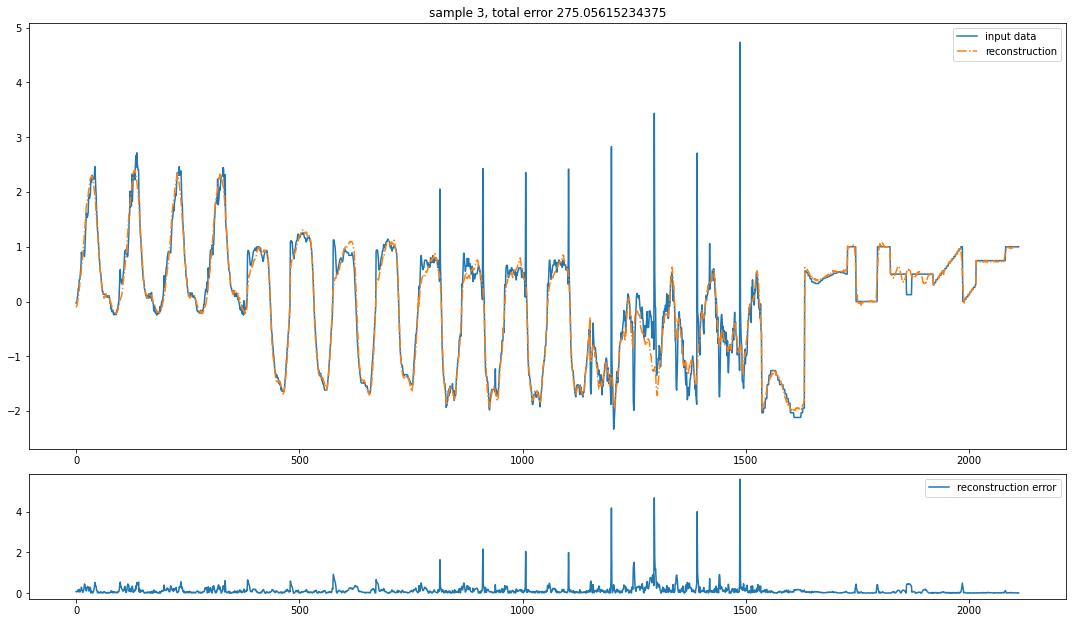

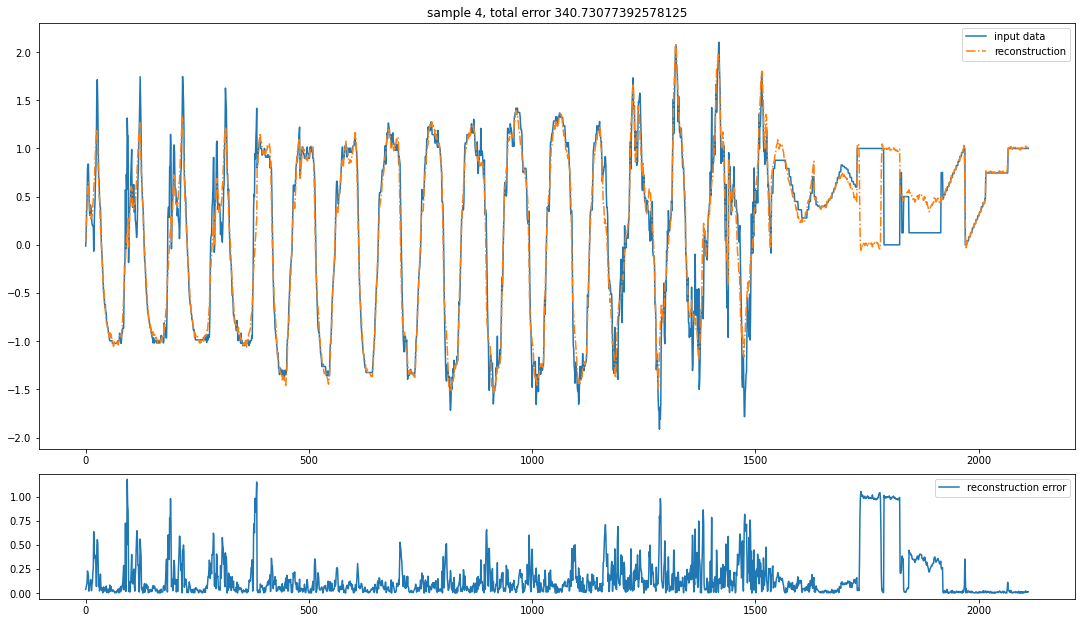

In [96]:
evaluate_model( model, dataLoaderTrain, targetDevice , 5)

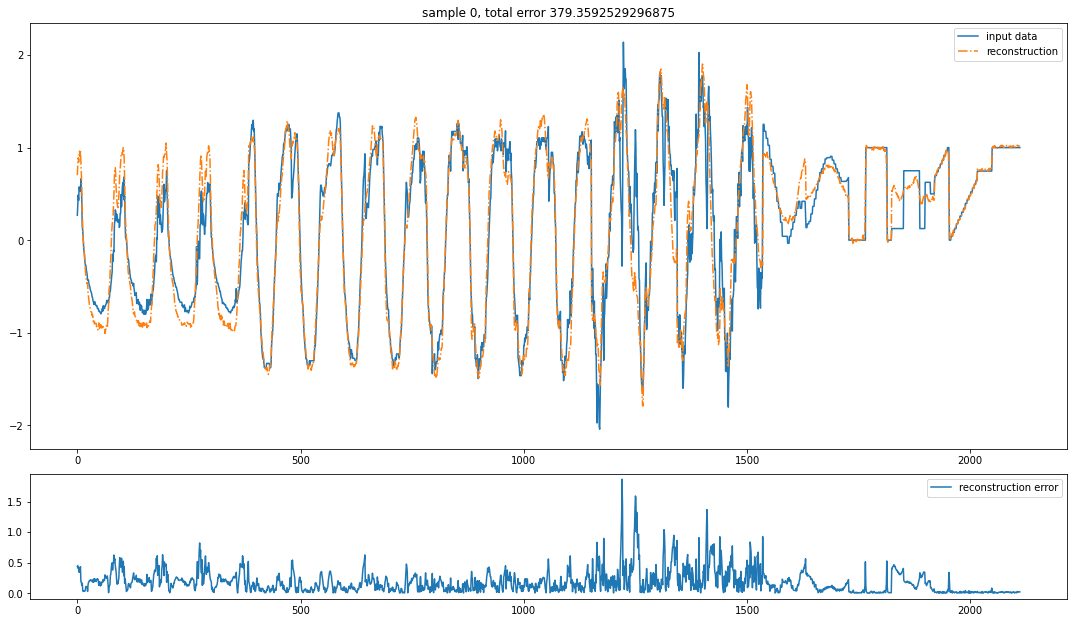

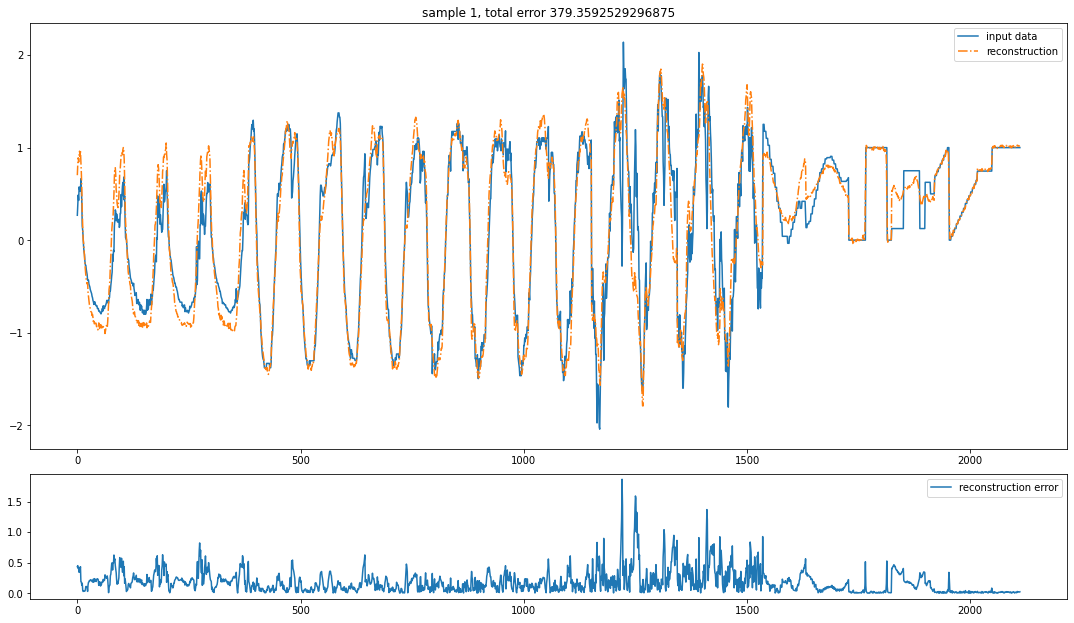

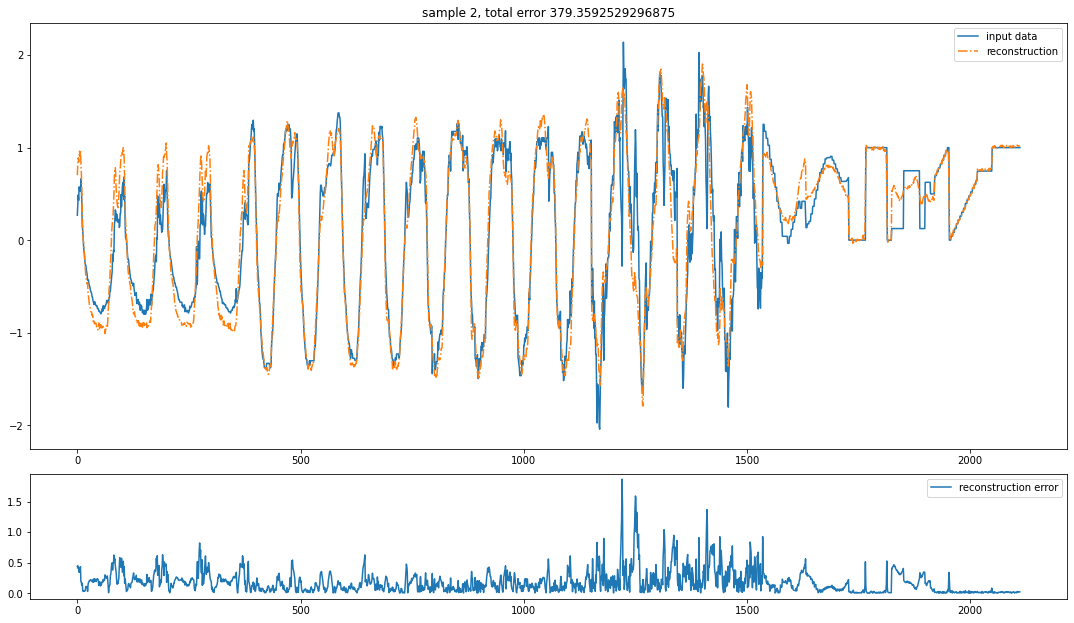

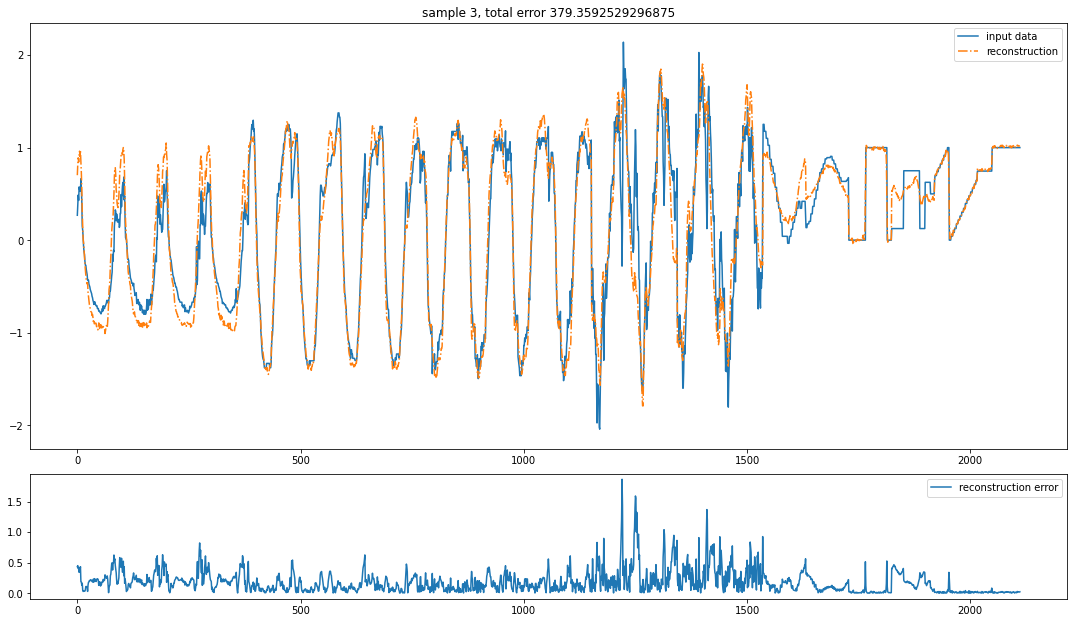

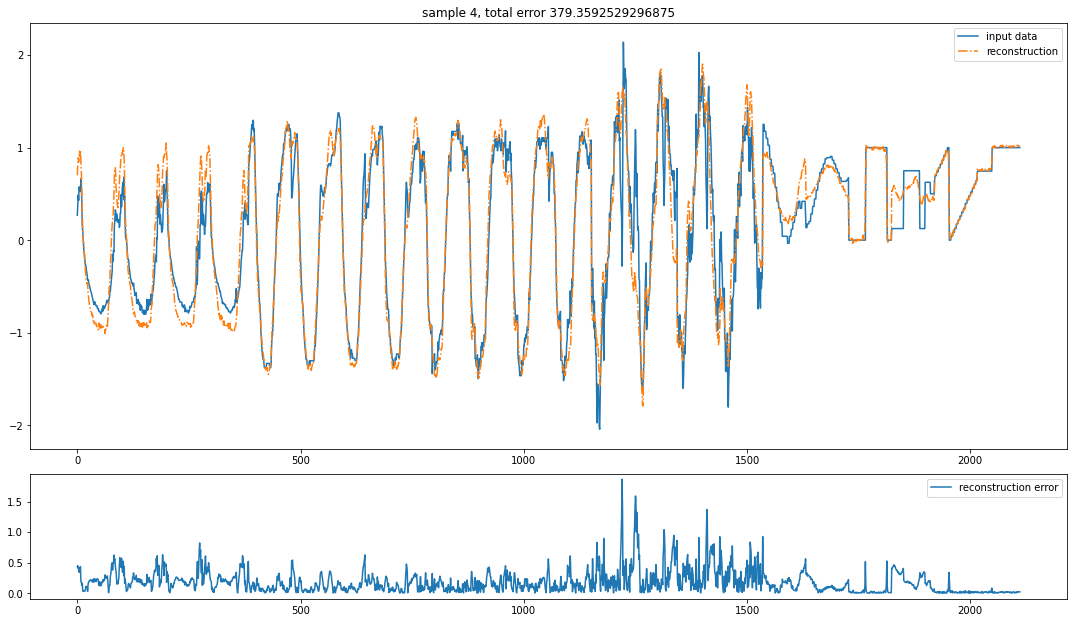

In [97]:
evaluate_model( model, dataLoaderTest, targetDevice , 5)

In [ ]:
# Retrain Model
# dataLoaderTrain = DataLoader( npTrainMatrix.astype('float32'), 
#                               batch_size = 128, 
#                               shuffle = True ) # could adjust batch size

In [64]:
# Testing the model
# test_data = joblib.load('test_dataset_2019.numpy')
dataLoaderTest = DataLoader( test_data.astype('float32'), 
                             batch_size = 1, 
                             shuffle = False )

# total_error_list = evaluate_reconstruction_loss( model, dataLoaderTest, targetDeviceGPU)
# np.mean(total_error_list)
# test_loss_df = pd.DataFrame(data=total_error_list, columns=['reconstruction_loss'])
# test_loss_df['threshold'] = 0.56 #threshold
# test_loss_df['anomoly'] = test_loss_df['reconstruction_loss'] > threshold
# test_loss_df.head()
# test_loss_df.anomoly.value_counts()

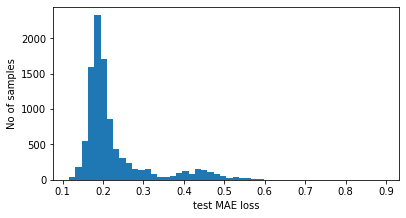

Number of anomaly samples:  178


In [139]:
# Get test MAE loss.
testingData = test_data.astype(np.float32)
x_test_pred = model.forward(torch.from_numpy(testingData))

test_mae_loss = np.mean(np.abs(testingData - x_test_pred.detach().numpy()), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.figure(figsize=(6,3)) 
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
# threshold = 0.45
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
# print("Indices of anomaly samples: ", np.where(anomalies))

In [66]:
test_mae_loss.shape

(9898,)

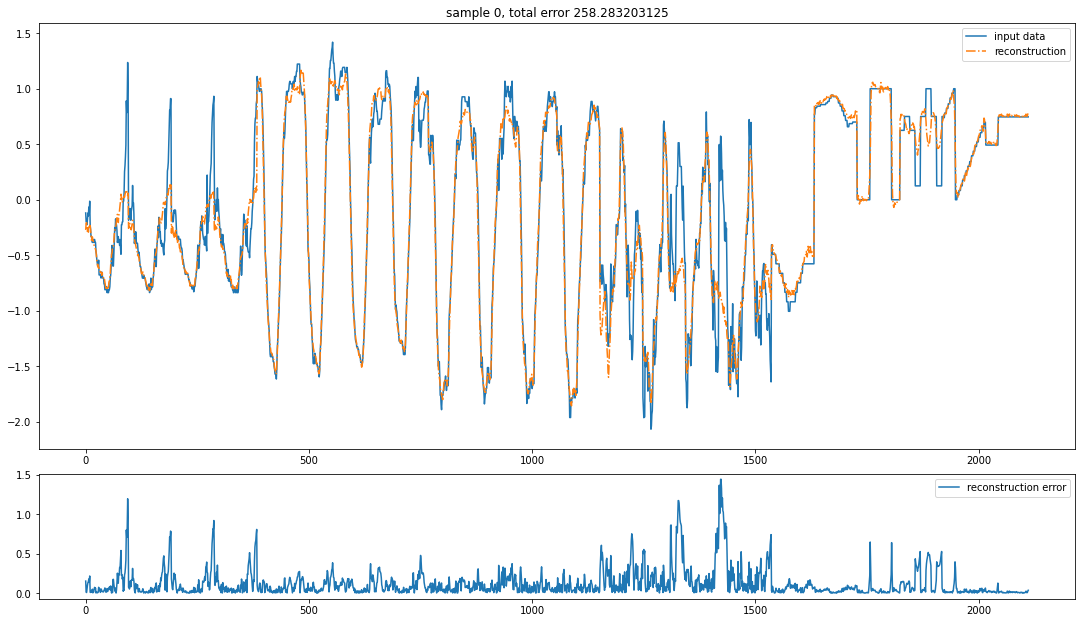

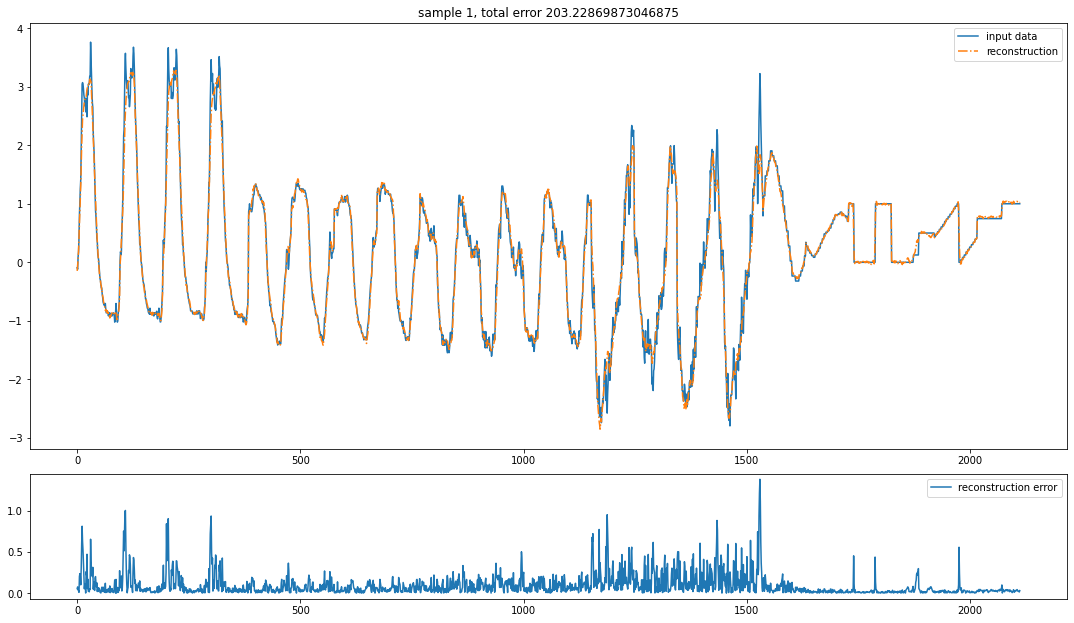

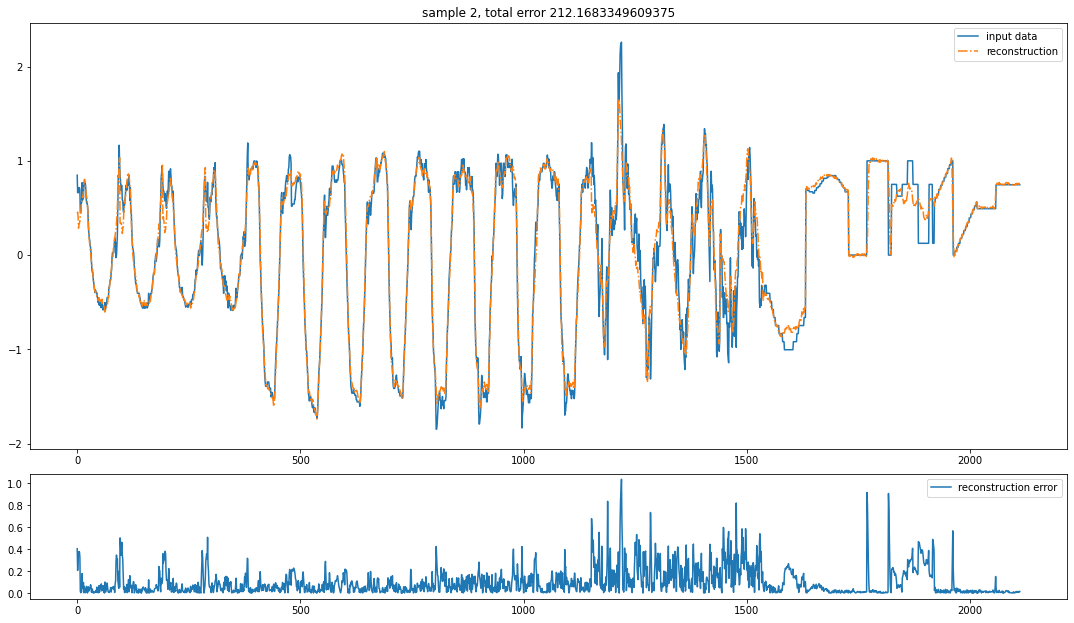

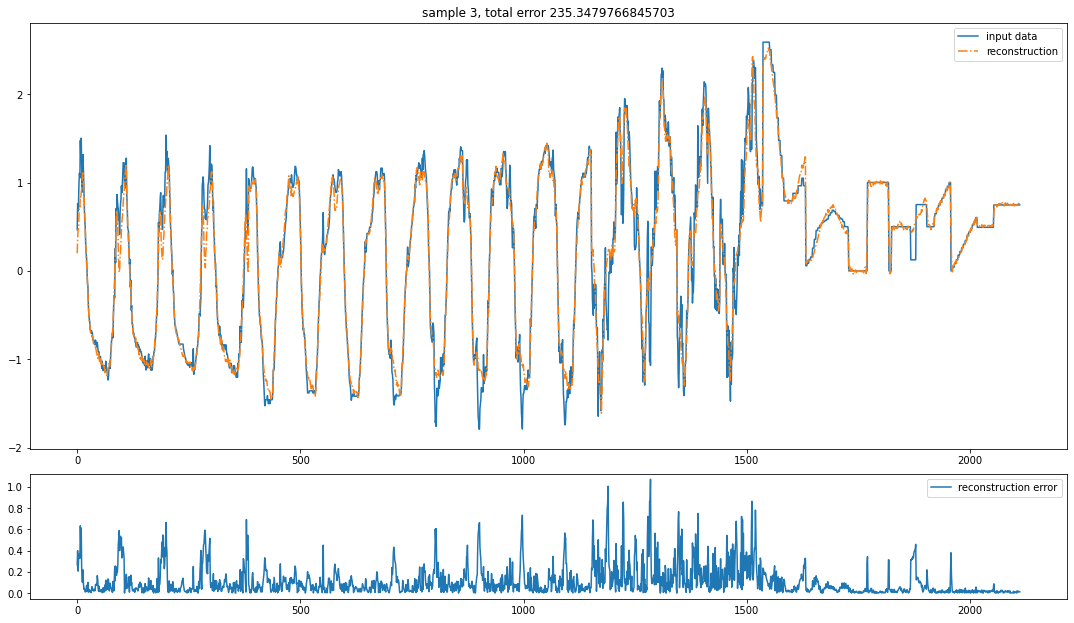

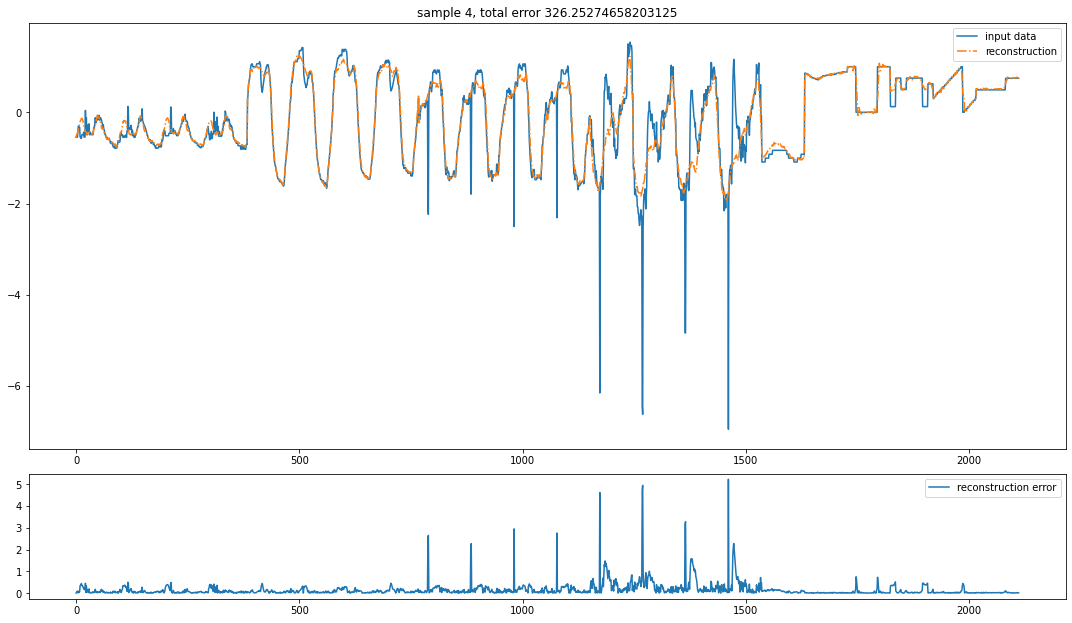

In [67]:
evaluate_model( model, dataLoaderTrain, targetDevice , 5)

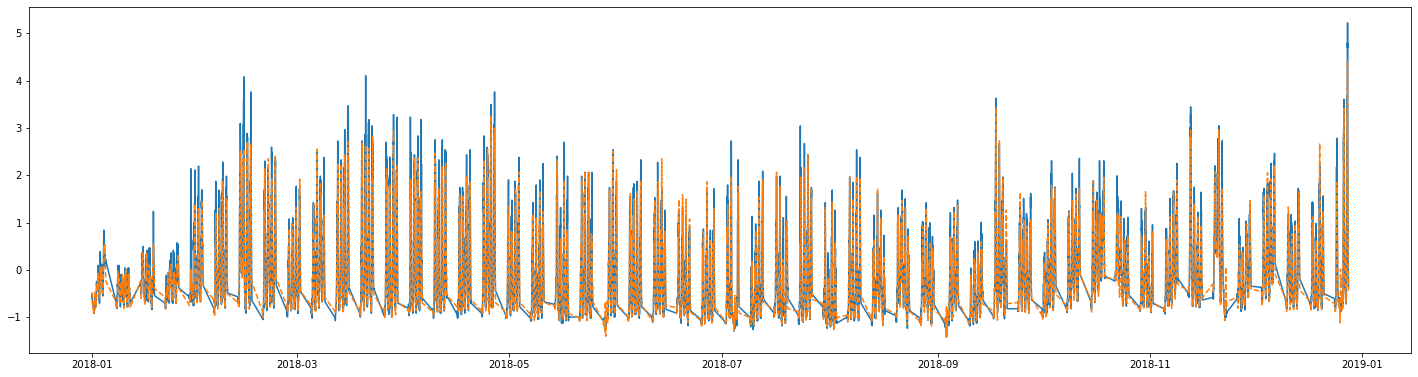

In [70]:
plt.figure(figsize=(24,6))
plt.plot(sampleIndexBounds[:,0], npTrainMatrix[:,0])
plt.plot(sampleIndexBounds[:,0], x_train_pred.detach().numpy()[:,0],'--')

In [ ]:
X_train.shape

In [ ]:
targetDevice = targetDeviceCPU

In [ ]:
from torch.autograd import Variable
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(targetDevice))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(targetDevice))
              
        x, (hidden_n, cell) = self.rnn1(x,(h_1, c_1))
        
        
        return hidden_n.reshape((self.n_features, self.embedding_dim))
        # return x, hidden , cell 

In [ ]:
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    
  def forward(self, x):
    x = x.reshape((-1, self.seq_len, self.n_features)) #2112 -> 22*96
    x, (_, _) = self.rnn1(x)
    # print("Xshape",x.shape)# 2112
    x, (hidden_n, cell) = self.rnn2(x)
    # print(hidden_n.shape)
    return hidden_n.reshape((self.n_features, self.embedding_dim)) # 96 -> 22*96
    # return hidden_n 

In [ ]:
class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
    
  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    # print(self.output_layer(x).shape)
    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(targetDevice)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(targetDevice)
    
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
seq_len = 2112 #96
n_features = 1 #22
model = RecurrentAutoencoder(seq_len, n_features, 5)
model = model.to(targetDevice)

In [ ]:
a = torch.from_numpy(np.arange(6))
a.shape

In [ ]:
a = a.unsqueeze(-1) 
a.shape

In [ ]:
a=a.reshape(6)
a.shape

In [ ]:
import copy
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  device = targetDevice
  criterion = nn.L1Loss()#(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
    
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true) #.unsqueeze(-1) 
      # loss = loss.reshape(-1,1)
      print(seq_true.shape)
      print(loss.shape)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    val_losses = []
    model = model.eval()
    
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true) #.unsqueeze(-1) 
        # loss = loss.reshape(-1,1)
        val_losses.append(loss.item())
        
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)

  return model.eval(), history, train_losses, val_losses

In [ ]:
model

In [ ]:
X_train.shape

In [ ]:
%%time
model, history, train_losses, val_losses = train_model(
  model,
  torch.tensor(X_train[:10,:]).float(),
  torch.tensor(test_data[:10,:]).float(),
  n_epochs=1
)

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
history['train']

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss()#(reduction='sum').to(targetDevice)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(targetDevice)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [ ]:
import seaborn as sns
_, losses = predict(model, torch.tensor(test_data[:50,:]).float())


In [ ]:
plt.figure(figsize= (10,3))
sns.distplot(losses, bins=50, kde=True);